Репозиторий на гитхабе: [medical_images_enhancement](https://github.com/djdjenny/medical_images_enchancement)

В этом ноутбуке представлен инференс - пример загрузки модели и обработки файлов с ее помощью.

# Необходимые пакеты, загрузка датасетов

In [19]:
import functools
from typing import Optional

In [54]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import torch
from torch import nn
from torchvision import transforms
from PIL import Image

In [2]:
!gdown --id 11NdtwNxcy24iLZLiL7lUaFH2oZ_XL3Cd -O ct_data.zip
!unzip -q /content/ct_data.zip -d /content/ct_data/

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=11NdtwNxcy24iLZLiL7lUaFH2oZ_XL3Cd
From (redirected): https://drive.google.com/uc?id=11NdtwNxcy24iLZLiL7lUaFH2oZ_XL3Cd&confirm=t&uuid=69b5dc7a-b4d8-4383-a1a9-9700efc4f0a1
To: /content/ct_data.zip
100% 8.15G/8.15G [03:09<00:00, 43.1MB/s]


In [3]:
!gdown --id 1467p-WDOl5vpOF5wPIBxRGFjB30XgNba -O us_train_data.zip
!mkdir /content/us_data/
!unzip -q /content/us_train_data.zip -d /content/us_data/

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1467p-WDOl5vpOF5wPIBxRGFjB30XgNba
From (redirected): https://drive.google.com/uc?id=1467p-WDOl5vpOF5wPIBxRGFjB30XgNba&confirm=t&uuid=200ec03d-63fb-4f24-a40c-c5bdfc28b92f
To: /content/us_train_data.zip
100% 70.7M/70.7M [00:01<00:00, 44.6MB/s]


# Загрузка модели

In [8]:
!gdown --id 1fI7FQxJydXwXgeOmNrXsiphoCzew1uxQ -O model.zip

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1fI7FQxJydXwXgeOmNrXsiphoCzew1uxQ
From (redirected): https://drive.google.com/uc?id=1fI7FQxJydXwXgeOmNrXsiphoCzew1uxQ&confirm=t&uuid=a4b91c8a-e953-49ee-afb9-56dcbcd9b617
To: /content/model.zip
100% 424M/424M [00:11<00:00, 36.2MB/s]


In [11]:
!unzip model.zip

Archive:  model.zip
   creating: content/ct_final_result/
   creating: content/ct_final_result/Discriminator_B/
  inflating: content/ct_final_result/Discriminator_B/Disc_B.pt  
   creating: content/ct_final_result/GAN_QD_to_FD/
  inflating: content/ct_final_result/GAN_QD_to_FD/GAN.pt  
   creating: content/ct_final_result/Discriminator_A/
  inflating: content/ct_final_result/Discriminator_A/Disc_A.pt  
   creating: content/ct_final_result/GAN_FD_to_QD/
  inflating: content/ct_final_result/GAN_FD_to_QD/GAN.pt  
  inflating: content/ct_final_result/history.pkl  


In [20]:
class UNetSkipConnectionLayer(nn.Module):
    def __init__(self, out_c, inner_c, outter=False, in_c=None, inner=False, use_drop=False,
                 norm_layer=nn.BatchNorm2d, submodule=False):
        super().__init__()
        self.outter = outter

        if in_c is None:
            in_c = out_c

        if type(norm_layer) == functools.partial:
            use_bias = (norm_layer.func == nn.InstanceNorm2d)
        else:
            use_bias = (norm_layer == nn.InstanceNorm2d)

        if self.outter:
            self.outconv = nn.Conv2d(2, out_c, kernel_size=1, stride=1)

        downrelu = nn.LeakyReLU(0.2, True)
        downConv = nn.Conv2d(in_c, inner_c, kernel_size=4, stride=2, padding=1, bias=use_bias)
        uprelu = nn.ReLU(True)
        upNorm = norm_layer(out_c)
        downNorm = norm_layer(inner_c)

        if inner:
            upConv = nn.ConvTranspose2d(inner_c, out_c, kernel_size=4, stride=2, padding=1, bias=use_bias)
            down = [downrelu, downConv]
            up = [uprelu, upConv, upNorm]
            layers = down + up
        elif outter:
            upConv = nn.ConvTranspose2d(inner_c * 2, out_c, kernel_size=4, stride=2, padding=1)
            down = [downConv]
            up = [uprelu, upConv]
            layers = down + [submodule] + up
        else:
            upConv = nn.ConvTranspose2d(inner_c * 2, out_c, kernel_size=4, stride=2, padding=1, bias=use_bias)
            down = [downrelu, downConv, downNorm]
            up = [uprelu, upConv, upNorm]
            if use_drop:
                layers = down + [submodule] + up + [nn.Dropout(0.5)]
            else:
                layers = down + [submodule] + up

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        if self.outter:
            return self.outconv(torch.cat([x, self.model(x)], dim=1))
        else:
            return torch.cat([x, self.model(x)], dim=1)


class UNetGenerator(nn.Module):
    def __init__(self, in_c, out_c, num_downs=8, ngf=64, norm_layer=nn.BatchNorm2d, use_drop=False):
        super().__init__()
        block = UNetSkipConnectionLayer(8 * ngf, 8 * ngf, inner=True, norm_layer=norm_layer)
        for i in range(num_downs - 5):
            block = UNetSkipConnectionLayer(8 * ngf, 8 * ngf, norm_layer=norm_layer, use_drop=use_drop, submodule=block)
        block = UNetSkipConnectionLayer(4 * ngf, 8 * ngf, norm_layer=norm_layer, submodule=block)
        block = UNetSkipConnectionLayer(2 * ngf, 4 * ngf, norm_layer=norm_layer, submodule=block)
        block = UNetSkipConnectionLayer(ngf, 2 * ngf, norm_layer=norm_layer, submodule=block)
        self.model = UNetSkipConnectionLayer(out_c, ngf, in_c=in_c, norm_layer=norm_layer, submodule=block, outter=True)

    def forward(self, x):
        return self.model(x)

# Обработка изображений

In [6]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [66]:
def load_model(model_path: str, task: Optional[str] = 'enhancement') -> torch.nn.Module:
    model = torch.load(model_path, weights_only=False, map_location=DEVICE)
    model.eval()
    return model.to(DEVICE)


def process_image(input_path: str, model_path: str) -> str:
    model = load_model(model_path)
    image = Image.open(input_path).convert("L")
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    input_tensor = transform(image).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        output = model(input_tensor)
    output_tensor = output.squeeze().clamp(0, 1).cpu()
    to_pil = transforms.ToPILImage()
    output_image = to_pil(output_tensor)
    result_path = input_path.replace(".png", "_processed.png")
    output_image.save(result_path)
    return result_path


def process_image_from_npy(input_path: str, model_path: str) -> str:
    model = load_model(model_path)
    data = np.load(input_path)
    tensor = torch.from_numpy(data)
    tensor = tensor.unsqueeze(0)
    tensor = tensor.float().unsqueeze(0)
    input_tensor = tensor.to(DEVICE)

    with torch.no_grad():
        output = model(input_tensor)
    output_tensor = output.squeeze().clamp(0, 1).cpu()
    to_pil = transforms.ToPILImage()
    output_image = to_pil(output_tensor)
    result_path = input_path.replace(".npy", "_processed.png")
    output_image.save(result_path)
    return result_path

In [13]:
GAN_PATH = '/content/content/ct_final_result/GAN_QD_to_FD/GAN.pt'

## Обработка УЗИ

Посмотрим на изображения в формате картинка высокого качества - сгенерированная картинка - картинка низкого качества.

In [49]:
us_high = '/content/us_data/train_datasets/breast/high_quality/1220.png'
us_low = '/content/us_data/train_datasets/breast/low_quality/1220.png'

In [50]:
output_path = process_image(us_low, GAN_PATH)
output_path

'/content/us_data/train_datasets/breast/low_quality/1220_processed.png'

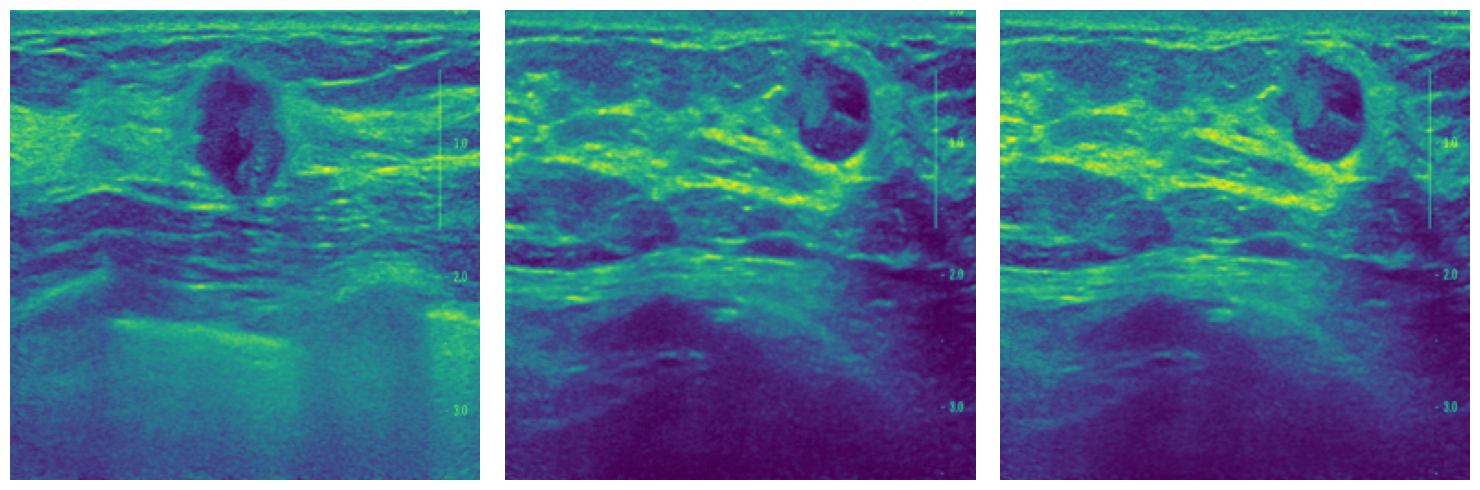

In [51]:
imgs = [us_high, output_path, us_low]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, img_path in zip(axes, imgs):
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

Из-за специфики датасета (изображения низкого и высокого качества получались вручную, нельзя сопоставить их пиксель-в-пиксель) данная модель не может сильно улучшить качество. Можно сказать, что она просто выкручивает контраст, увеличивая PSNR.

## Обработка КТ

Аналогичный формат: картинка высокого качества - сгенерированная картинка - картинка низкого качества.

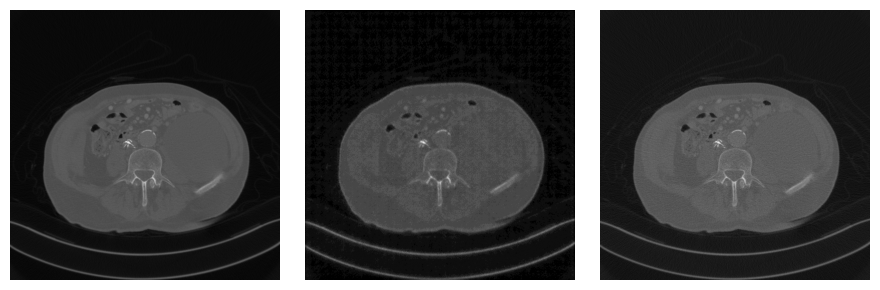

In [84]:
ct_high = '/content/ct_data/data/test/fd/162.npy'
ct_low = '/content/ct_data/data/test/qd/162.npy'

output_path = process_image_from_npy(ct_low, GAN_PATH)

imgs = [ct_high, output_path, ct_low]

fig, axes = plt.subplots(1, 3, figsize=(9, 3))

img_png = mpimg.imread(output_path)
img_high = np.load(ct_high)
img_low = np.load(ct_low)


axes[1].imshow(img_png, cmap='gray')
axes[1].axis('off')

axes[0].imshow(img_high, cmap='gray')
axes[0].axis('off')

axes[2].imshow(img_low, cmap='gray')
axes[2].axis('off')

plt.tight_layout()
plt.show()

Видим, что на ихображении увеличена зернистость. В изображении низкого качества есть полосы, проходящие в разных направлениях через все изображение. В модели они исчезают ценой плавности изображения. Для данной задачи это опасно - избыточная фрагментация изображений может вести к неверным диагнозам.

У авторов такой проблемы с зернистостью не наблюдалось, но оставались полосы. Можно предположить, что это из-за более длительного обучения, однако веса данной модели зафиксировались до 80 эпохи (столько ставили авторы).